In [2]:
from sagemaker import get_execution_role

role = get_execution_role()
bucket='sage-maker-bucket-pmc'

In [4]:
%%time
import pickle, gzip, numpy, urllib.request, json

# Load the dataset
urllib.request.urlretrieve("http://deeplearning.net/data/mnist/mnist.pkl.gz", "mnist.pkl.gz")
with gzip.open('mnist.pkl.gz', 'rb') as f:
    train_set, valid_set, test_set = pickle.load(f, encoding='latin1')

CPU times: user 828 ms, sys: 308 ms, total: 1.14 s
Wall time: 2.21 s


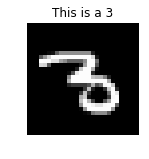

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (2,10)


def show_digit(img, caption='', subplot=None):
    if subplot==None:
        _,(subplot)=plt.subplots(1,1)
    imgr=img.reshape((28,28))
    subplot.axis('off')
    subplot.imshow(imgr, cmap='gray')
    plt.title(caption)

show_digit(train_set[0][30], 'This is a {}'.format(train_set[1][30]))

In [14]:
%%time
from sagemaker.amazon.common import write_numpy_to_dense_tensor
import io
import boto3

data_key = 'kmeans_lowlevel_example/data'
data_location = 's3://{}/{}'.format(bucket, data_key)
print('training data will be uploaded to: {}'.format(data_location))

# Convert the training data into the format required by the SageMaker KMeans algorithm
buf = io.BytesIO()
write_numpy_to_dense_tensor(buf, train_set[0], train_set[1])
buf.seek(0)

boto3.resource('s3').Bucket(bucket).Object(data_key).upload_fileobj(buf)

training data will be uploaded to: s3://sage-maker-bucket-pmc/kmeans_lowlevel_example/data
CPU times: user 7.84 s, sys: 264 ms, total: 8.11 s
Wall time: 9.46 s


In [16]:
from sagemaker import KMeans

data_location = 's3://{}/kmeans_highlevel_example/data'.format(bucket)
output_location = 's3://{}/kmeans_example/output'.format(bucket)

print('training data will be uploaded to: {}'.format(data_location))
print('training artifacts will be uploaded to: {}'.format(output_location))

kmeans = KMeans(role=role,
                train_instance_count=2,
                train_instance_type='ml.c4.8xlarge',
                output_path=output_location,
                k=10,
                data_location=data_location)

training data will be uploaded to: s3://sage-maker-bucket-pmc/kmeans_highlevel_example/data
training artifacts will be uploaded to: s3://sage-maker-bucket-pmc/kmeans_example/output


In [17]:
%%time

kmeans.fit(kmeans.record_set(train_set[0]))

INFO:sagemaker:Creating training-job with name: kmeans-2018-07-12-17-56-34-937


..........................
Docker entrypoint called with argument(s): train
Docker entrypoint called with argument(s): train
[07/12/2018 18:00:48 INFO 139957363558208] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/default-input.json: {u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'local_lloyd_num_trials': u'auto', u'_log_level': u'info', u'_kvstore': u'auto', u'local_lloyd_init_method': u'kmeans++', u'force_dense': u'true', u'epochs': u'1', u'init_method': u'random', u'local_lloyd_tol': u'0.0001', u'local_lloyd_max_iter': u'300', u'_disable_wait_to_read': u'false', u'extra_center_factor': u'auto', u'eval_metrics': u'["msd"]', u'_num_kv_servers': u'1', u'mini_batch_size': u'5000', u'half_life_time_size': u'0', u'_num_slices': u'1'}
[07/12/2018 18:00:48 INFO 139957363558208] Reading provided configuration from /opt/ml/input/config/hyperparameters.json: {u'feature_dim': u'784', u'k': u'10', u'force_dense': u'True'}
[07/12/2018 18:00:48 IN

===== Job Complete =====
Billable seconds: 198
CPU times: user 7.34 s, sys: 464 ms, total: 7.8 s
Wall time: 4min 53s


In [18]:
%%time

kmeans_predictor = kmeans.deploy(initial_instance_count=1,
                                 instance_type='ml.m4.xlarge')

INFO:sagemaker:Creating model with name: kmeans-2018-07-12-18-10-47-767
INFO:sagemaker:Creating endpoint with name kmeans-2018-07-12-17-56-34-937


----------------------------------------------------------------!CPU times: user 284 ms, sys: 12 ms, total: 296 ms
Wall time: 5min 24s


In [19]:
result = kmeans_predictor.predict(valid_set[0][30:31])
print(result)

[label {
  key: "closest_cluster"
  value {
    float32_tensor {
      values: 9.0
    }
  }
}
label {
  key: "distance_to_cluster"
  value {
    float32_tensor {
      values: 5.525047779083252
    }
  }
}
]


In [20]:
%%time 

result = kmeans_predictor.predict(valid_set[0][0:100])
clusters = [r.label['closest_cluster'].float32_tensor.values[0] for r in result]

CPU times: user 20 ms, sys: 0 ns, total: 20 ms
Wall time: 107 ms





Cluster 0:


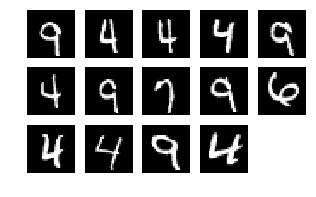




Cluster 1:


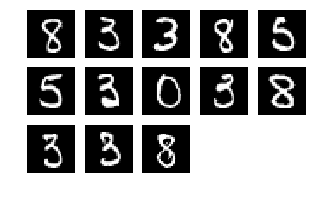




Cluster 2:


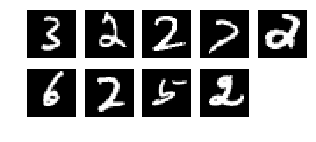




Cluster 3:


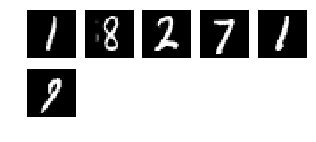




Cluster 4:


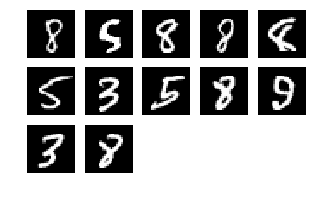




Cluster 5:


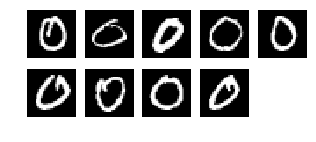




Cluster 6:


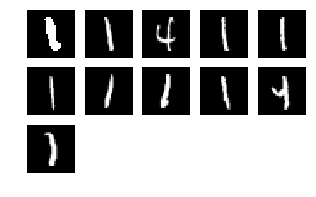




Cluster 7:


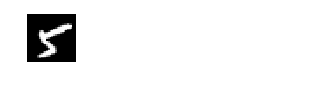




Cluster 8:


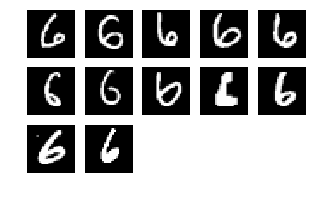




Cluster 9:


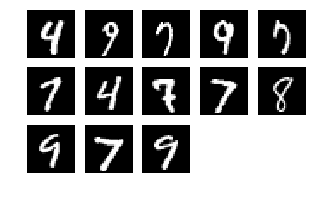

In [21]:
for cluster in range(10):
    print('\n\n\nCluster {}:'.format(int(cluster)))
    digits = [ img for l, img in zip(clusters, valid_set[0]) if int(l) == cluster ]
    height=((len(digits)-1)//5)+1
    width=5
    plt.rcParams["figure.figsize"] = (width,height)
    _, subplots = plt.subplots(height, width)
    subplots=numpy.ndarray.flatten(subplots)
    for subplot, image in zip(subplots, digits):
        show_digit(image, subplot=subplot)
    for subplot in subplots[len(digits):]:
        subplot.axis('off')

    plt.show()

In [1]:
from sagemaker import get_execution_role

role = get_execution_role()
bucket='sage-maker-bucket-pmc'

In [2]:
import pandas as pd
import urllib.request

data_filename = 'SM+Pmc.csv'
data_source = 'https://s3.amazonaws.com/sage-maker-bucket-pmc/SM+Pmc.csv'

urllib.request.urlretrieve(data_source, data_filename)
train_set= pd.read_csv(data_filename, delimiter=',')

In [3]:
train_set.head()
print(train_set.loc[0:5,:])

          pctype                                           sentence
0        rebelle                                                :-)
1    perseverant  À mon avis, il faudra surveiller comment il év...
2        rebelle                        À mort le projet annuel !!!
3  travaillomane  À partir de empathie9travaillomane9, il étudie...
4  travaillomane  A quelle date avez vous transmis les élément ?...
5    perseverant             À votre avis que devrions-nous faire ?


In [7]:
train_set.loc[0:5,"sentence"]
train_set_sentence=train_set.loc[0:,"sentence"].as_matrix()
train_set_pctype = train_set.loc[0:,"pctype"].as_matrix()

AttributeError: 'numpy.ndarray' object has no attribute 'loc'

In [36]:
%%time
from sagemaker.amazon.common import write_numpy_to_dense_tensor
import io
import boto3

data_key = 'kmeans_lowlevel_example/data'
data_location = 's3://{}/{}'.format(bucket, data_key)
print('training data will be uploaded to: {}'.format(data_location))

# Convert the training data into the format required by the SageMaker KMeans algorithm
buf = io.BytesIO()
write_numpy_to_dense_tensor(buf, train_set, train_set)
buf.seek(0)

boto3.resource('s3').Bucket(bucket).Object(data_key).upload_fileobj(buf)

training data will be uploaded to: s3://sage-maker-bucket-pmc/kmeans_lowlevel_example/data


ValueError: Labels must be a Vector

In [48]:
print(train_set)

[['rebelle' ':-)']
 ['perseverant' 'À mon avis, il faudra surveiller comment il évolue.']
 ['rebelle' 'À mort le projet annuel !!!']
 ...
 ['rebelle' 'Y a papa qui reppasse au boulot au final.']
 ['rebelle' "Y'a aucun de ces sujets qui me branchent."]
 ['rebelle' 'Youpi !']]
